In [2]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File path to the dataset
filepath = '/content/drive/My Drive/nasdaq/nasdq.csv'

# Try loading the dataset
try:
    data = pd.read_csv(filepath)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: File not found.")
except pd.errors.ParserError:
    print("Error: Issue with file formatting.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Mounted at /content/drive
Dataset loaded successfully!


In [3]:
# Define lag period
lag_period = 1

# Create lagged features for the dataset
def create_features(df, lag_period):
    """Create lagged features for time series prediction."""
    df = df.copy()
    try:
        df[f'Prev_{lag_period}_Open'] = df['Open'].shift(lag_period)
        df[f'Prev_{lag_period}_Low'] = df['Low'].shift(lag_period)
        df[f'Prev_{lag_period}_High'] = df['High'].shift(lag_period)
    except KeyError as e:
        print(f"Error: Missing column - {e}")
        return df  # Return the original dataframe if columns are missing
    return df

# Apply lagged feature creation
try:
    data = create_features(data, lag_period)
    # Drop rows with NaN values caused by lagging
    data = data.dropna()
    print("Lagged features created successfully!")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Display a sample of the modified data
print(data.head())


Lagged features created successfully!
         Date      Open      High       Low     Close     Volume  \
1  2010-01-05  6.643333  6.773333  6.643333  6.766667  4445100.0   
2  2010-01-06  6.733333  6.786667  6.720000  6.763333  7340100.0   
3  2010-01-07  6.750000  6.766667  6.630000  6.673333  8498400.0   
4  2010-01-08  6.676667  6.766667  6.626667  6.743333  4347600.0   
5  2010-01-11  6.746667  6.800000  6.700000  6.760000  5364300.0   

   InterestRate  ExchangeRate    VIX  TEDSpread  EFFR         Gold        Oil  \
1          0.11        1.4402  19.35       0.18  0.12  1118.099976  81.769997   
2          0.11        1.4404  19.16       0.19  0.12  1135.900024  83.180000   
3          0.11        1.4314  19.06       0.20  0.10  1133.099976  82.660004   
4          0.11        1.4357  18.13       0.20  0.11  1138.199951  82.750000   
5          0.11        1.4536  17.55       0.21  0.11  1150.699951  82.519997   

   Prev_1_Open  Prev_1_Low  Prev_1_High  
1     6.640000    6.6333

In [4]:
from sklearn.model_selection import train_test_split

# Define selected features and target columns
selected_features = ['Open', f'Prev_{lag_period}_Open',
                     f'Prev_{lag_period}_Low',
                     f'Prev_{lag_period}_High']
targets = ['High', 'Low']

try:
    # Check if all columns exist
    missing_features = [col for col in selected_features if col not in data.columns]
    missing_targets = [col for col in targets if col not in data.columns]

    if missing_features or missing_targets:
        raise ValueError(f"Missing columns: {missing_features + missing_targets}")

    # Select features and targets
    X = data[selected_features]
    y = data[targets]

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    print("Train-test split successful!")
    print(f"Training data size: {X_train.shape}, Testing data size: {X_test.shape}")

except Exception as e:
    print(f"Error: {e}")

Train-test split successful!
Training data size: (3130, 4), Testing data size: (783, 4)


In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Fit separate scalers for 'High' and 'Low'
scaler_y_high = MinMaxScaler()
scaler_y_low = MinMaxScaler()

try:
    # Ensure target columns exist in training and testing sets
    if 'High' not in y_train.columns or 'Low' not in y_train.columns:
        raise ValueError("Missing 'High' or 'Low' in training targets.")
    if 'High' not in y_test.columns or 'Low' not in y_test.columns:
        raise ValueError("Missing 'High' or 'Low' in testing targets.")

    # Fit and transform training and testing data for 'High'
    y_train_high_scaled = scaler_y_high.fit_transform(y_train[['High']])
    y_test_high_scaled = scaler_y_high.transform(y_test[['High']])

    # Fit and transform training and testing data for 'Low'
    y_train_low_scaled = scaler_y_low.fit_transform(y_train[['Low']])
    y_test_low_scaled = scaler_y_low.transform(y_test[['Low']])

    print("Scaling successful!")
    print(f"Scaled 'High' training data: {y_train_high_scaled[:5]}")
    print(f"Scaled 'Low' training data: {y_train_low_scaled[:5]}")

except Exception as e:
    print(f"An error occurred: {e}")

# Ensure inputs are scaled
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Combine scaled target columns
y_train_scaled = np.hstack([y_train_high_scaled, y_train_low_scaled])

# Check shapes of inputs
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

Scaling successful!
Scaled 'High' training data: [[0.01303178]
 [0.01323462]
 [0.01293038]
 [0.01293038]
 [0.01343745]]
Scaled 'Low' training data: [[0.01412356]
 [0.01530481]
 [0.01391813]
 [0.01386678]
 [0.01499666]]
X_train_scaled shape: (3130, 4)
y_train_scaled shape: (3130, 2)


In [9]:
import xgboost as xgb
# Train XGBoost models for 'High' and 'Low'
model_high = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model_low = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Fit models
try:
    model_high.fit(X_train_scaled, y_train_high_scaled.ravel())  # Train model for 'High'
    model_low.fit(X_train_scaled, y_train_low_scaled.ravel())   # Train model for 'Low'
    print("Models trained successfully!")
except Exception as e:
    print(f"Error during training: {e}")

Models trained successfully!


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
# Predictions
try:
    # Predict on scaled test data
    y_pred_high_scaled = model_high.predict(X_test_scaled)
    y_pred_low_scaled = model_low.predict(X_test_scaled)

    # Inverse-transform predictions to original scale
    y_pred_high = scaler_y_high.inverse_transform(y_pred_high_scaled.reshape(-1, 1)).flatten()
    y_pred_low = scaler_y_low.inverse_transform(y_pred_low_scaled.reshape(-1, 1)).flatten()

    # Evaluate the models
    mse_high = mean_squared_error(y_test['High'], y_pred_high)
    r2_high = r2_score(y_test['High'], y_pred_high)

    mse_low = mean_squared_error(y_test['Low'], y_pred_low)
    r2_low = r2_score(y_test['Low'], y_pred_low)

    # Convert R² to percentages
    r2_high_percentage = r2_high * 100
    r2_low_percentage = r2_low * 100

    # Display evaluation metrics
    print("\nModel Evaluation Metrics:")

    # Metrics for 'High'
    print("\nHigh Target:")
    print(f"Mean Squared Error (MSE): {mse_high:.4f}")
    print(f"R-squared (R²): {r2_high:.4f} ({r2_high_percentage:.2f}%)")

    # Metrics for 'Low'
    print("\nLow Target:")
    print(f"Mean Squared Error (MSE): {mse_low:.4f}")
    print(f"R-squared (R²): {r2_low:.4f} ({r2_low_percentage:.2f}%)")

except Exception as e:
    print(f"Error during prediction or evaluation: {e}")


Model Evaluation Metrics:

High Target:
Mean Squared Error (MSE): 1.2618
R-squared (R²): 0.9699 (96.99%)

Low Target:
Mean Squared Error (MSE): 1.4802
R-squared (R²): 0.9639 (96.39%)


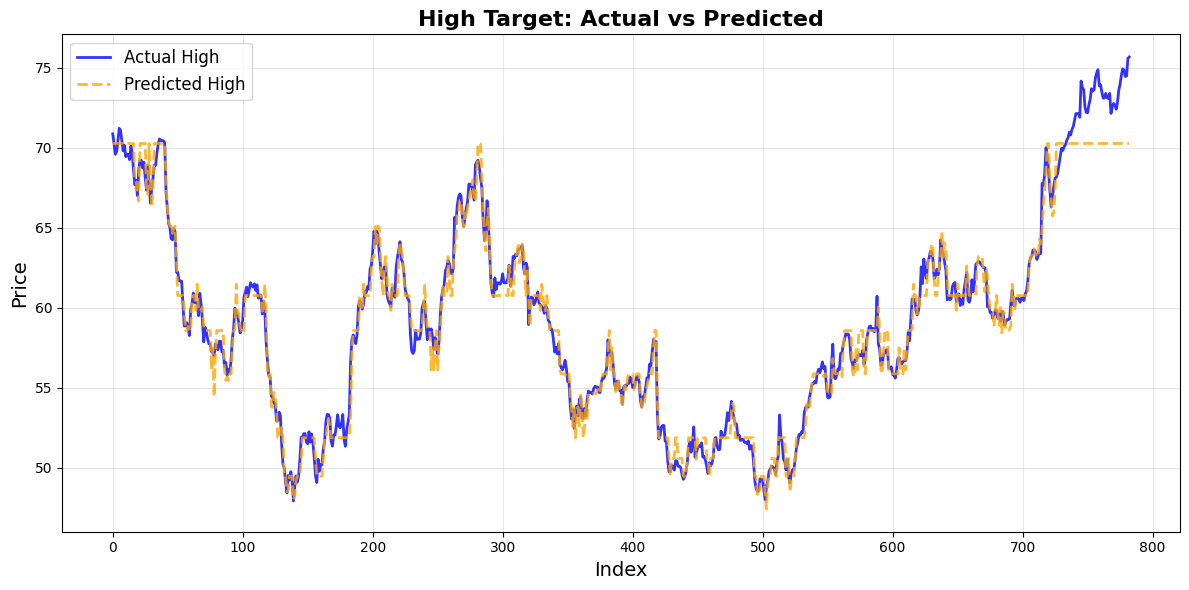

In [ ]:
import matplotlib.pyplot as plt
# High Target: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test['High'].values, label='Actual High', color='blue', alpha=0.8, linewidth=2)
plt.plot(y_pred_high, label='Predicted High', color='orange', alpha=0.8, linestyle='--', linewidth=2)
plt.title('High Target: Actual vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

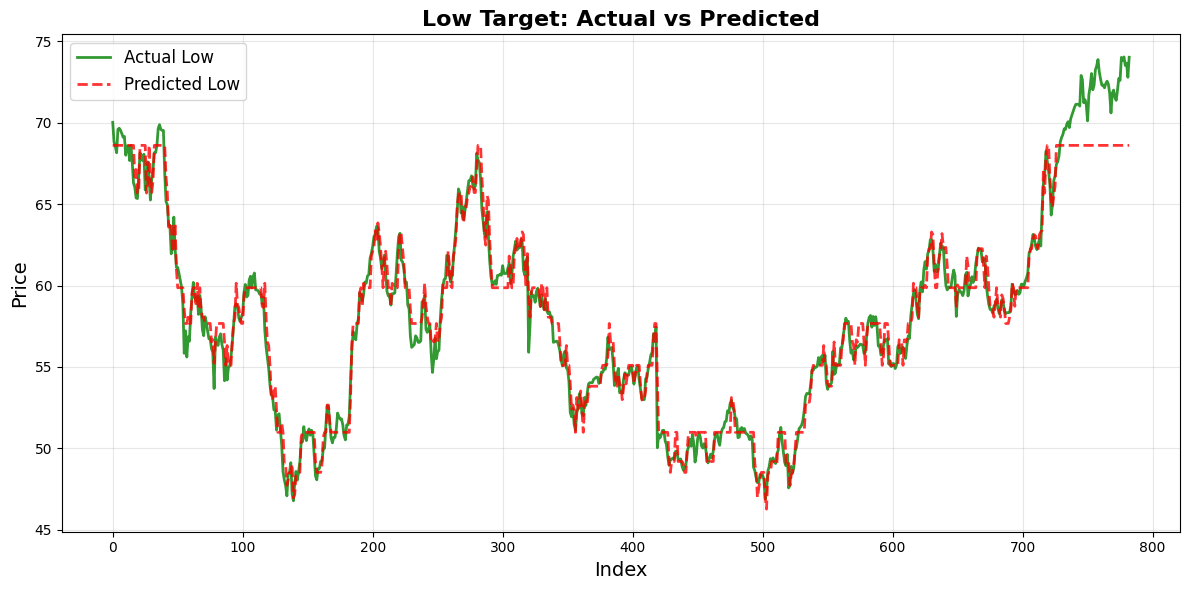

In [ ]:
# Low Target: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test['Low'].values, label='Actual Low', color='green', alpha=0.8, linewidth=2)
plt.plot(y_pred_low, label='Predicted Low', color='red', alpha=0.8, linestyle='--', linewidth=2)
plt.title('Low Target: Actual vs Predicted', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

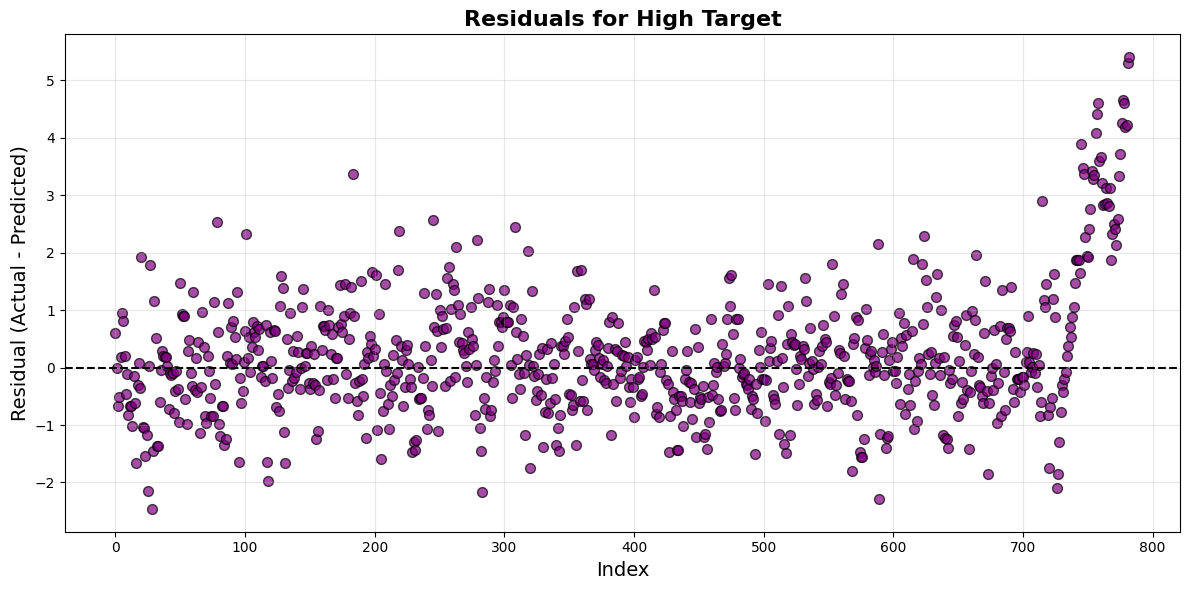

In [ ]:
# Residuals for High
residuals_high = y_test['High'].values - y_pred_high

plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals_high)), residuals_high, color='purple', alpha=0.7, edgecolor='k', s=50)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.title('Residuals for High Target', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Residual (Actual - Predicted)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

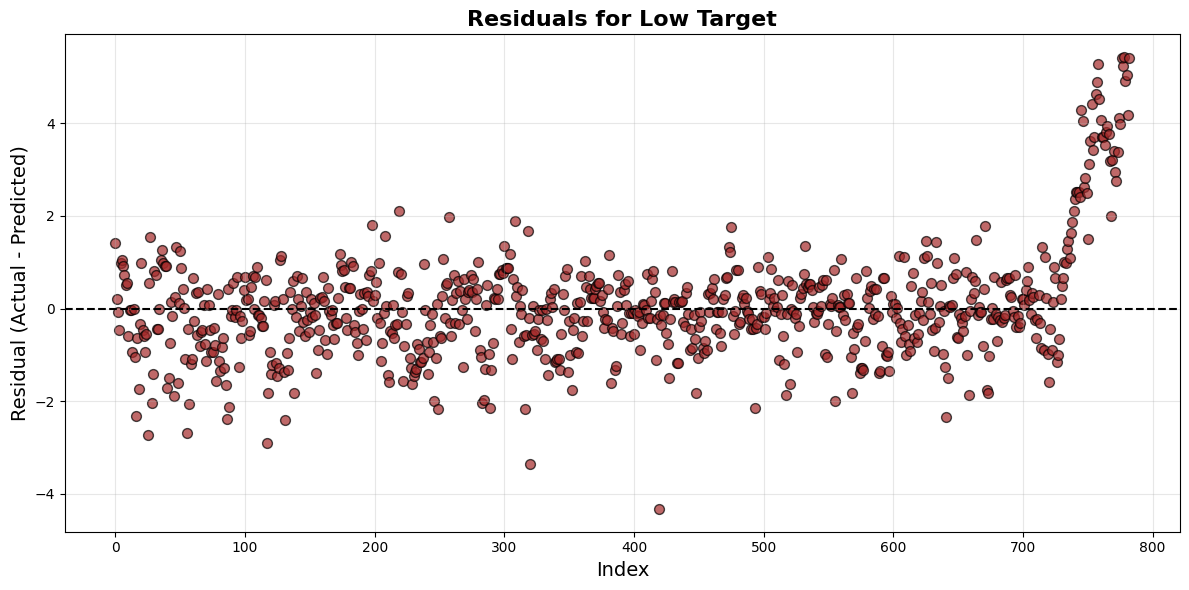

In [ ]:
# Residuals for Low
residuals_low = y_test['Low'].values - y_pred_low

plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals_low)), residuals_low, color='brown', alpha=0.7, edgecolor='k', s=50)
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.title('Residuals for Low Target', fontsize=16, fontweight='bold')
plt.xlabel('Index', fontsize=14)
plt.ylabel('Residual (Actual - Predicted)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Import joblib for saving the model
import joblib

# Save the trained XGBoost model
joblib.dump(xgb_model, '/content/xgb_model.pkl')
print("Model saved successfully as 'xgb_model.pkl'.")

Model saved successfully as 'xgb_model.pkl'.
